In [1]:
# Run this to install tensorflow version 1.9
# !pip install -q tensorflow==1.9
# Make sure you RESTART RUNTIME (Runtime->Restart Runtime) after running this

In [2]:
import gym
import random
import numpy as np
print("Gym:", gym.__version__)

Gym: 0.10.11


In [3]:
env_name = "Pendulum-v0"
# env_name = "MountainCarContinuous-v0"
# env_name = "LunarLanderContinuous-v2"
env = gym.make(env_name)
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

Observation space: Box(3,)
Action space: Box(1,)


#### Tensorflow QNetwork

Below is the implementation of an Actor Critic network using tensorflow as the backend model. This contains a tensorflow session and after initially building the network graph, it is trained by running the optimizer with the state, action for accessing the action and q values and the next_state, reward and done for calculating the q_target values for training.

In [5]:
import tensorflow as tf
print("Tensorflow:", tf.__version__)

class TFACNetwork():
    def __init__(self, state_size, action_size, action_range):
        tf.reset_default_graph()
        self.state_in = tf.placeholder(tf.float32, shape=[None, state_size])
        self.action_in = tf.placeholder(tf.float32, shape=[None, action_size])
        self.next_state_in = tf.placeholder(tf.float32, shape=[None, state_size])
        self.reward_in = tf.placeholder(tf.float32, shape=[None])
        self.done_in = tf.placeholder(tf.float32, shape=[None])

        self.action_low, self.action_high = action_range
        self.actor_local = self.build_actor(action_size, scope="actor_local")
        self.actor_target = self.build_actor(action_size, scope="actor_target")
        self.critic_local = self.build_critic(self.state_in, self.action_in, scope="critic_local")
        self.critic_target = self.build_critic(self.next_state_in, self.actor_target, scope="critic_target")

        self.optimizer = self.build_optimizer()
        self.updater = self.build_updater()
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
          
    def build_actor(self, action_size, scope=None):
        with tf.variable_scope(scope):
            layer1 = tf.layers.dense(self.state_in, 100, activation=tf.nn.relu)
            layer2 = tf.layers.dense(layer1, 100, activation=tf.nn.relu)
            layer3 = tf.layers.dense(layer2, 100, activation=tf.nn.relu)
            action_raw = tf.layers.dense(layer3, action_size, activation=None)
            action_scaled = self.action_low + (self.action_high - self.action_low) * tf.nn.sigmoid(action_raw)
            return action_scaled

    def build_critic(self, state, action, scope=None, reuse=False):
        with tf.variable_scope(scope):
            net_state = tf.layers.dense(state, 100, activation=tf.nn.relu, reuse=reuse, name="critic1")
            net_action = tf.layers.dense(action, 100, activation=tf.nn.relu, reuse=reuse, name="critic2")
            net_state_action = tf.concat([net_state, net_action], axis=1)
            net_layer = tf.layers.dense(net_state_action, 100, activation=tf.nn.relu, reuse=reuse, name="critic3")
            q_value = tf.layers.dense(net_layer, 1, activation=None, reuse=reuse, name="critic4")
            return q_value
        
    def build_updater(self, tau=0.01):
        actor_update_ops = [tf.assign(t, t+tau*(l-t)) for l,t in zip(self.get_vars("actor_local"), self.get_vars("actor_target"))]
        critic_update_ops = [tf.assign(t, t+tau*(l-t)) for l,t in zip(self.get_vars("critic_local"), self.get_vars("critic_target"))]
        updater = tf.group(*actor_update_ops, *critic_update_ops)
        return updater
        
    def build_optimizer(self, learn_rate=0.00025, gamma=0.97):
        rewards = tf.expand_dims(self.reward_in, axis=1)
        dones = tf.expand_dims(self.done_in, axis=1)
        q_targets = rewards + gamma * self.critic_target * (1-dones)
        critic_error = q_targets - self.critic_local
        critic_loss = tf.reduce_mean(tf.square(critic_error))
        critic_optimizer = tf.train.AdamOptimizer(learn_rate).minimize(critic_loss, var_list=self.get_vars("critic_local"))
        
        actor_trainer = self.build_critic(self.state_in, self.actor_local, scope="critic_local", reuse=True)
        actor_gain = tf.reduce_mean(actor_trainer - self.critic_local)
        actor_optimizer = tf.train.AdamOptimizer(learn_rate).minimize(-actor_gain, var_list=self.get_vars("actor_local"))
        
        optimizer = tf.group(actor_optimizer, critic_optimizer)
        return optimizer
        
    def get_vars(self, scope):
        return tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope)
    
    def update_model(self, state, action, next_state, reward, done):
        feed = {self.state_in: state, self.action_in: action, self.next_state_in: next_state, self.reward_in: reward, self.done_in: done}
        self.sess.run([self.optimizer, self.updater], feed_dict=feed)
        
    def get_action(self, state):
        action = self.sess.run(self.actor_local, feed_dict={self.state_in: state})
        return action
    
    def __del__(self):
        self.sess.close()

Tensorflow: 1.9.0


#### Pytorch QNetwork

Below is the implementation of an Actor Critic network using pytorch as the backend model. This involves first defining a Model class for both the Actor and Critic which subclasses the pytorch nn.Module class and then defines the network graph which can be run with the forward function.

Then the Model is included in an enclosing PTQNetwork class which trains the model by taking in the states and running the Model class to get the q values which are then indexed by the actions and then the gradients are calculated from the MSE loss between the predicted q value and the q_target.

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
print("Torch:", torch.__version__)

class Actor(nn.Module):
    def __init__(self, state_size, action_size, action_range):
        super().__init__()
        self.action_low, self.action_high = torch.from_numpy(np.array(action_range))
        self.layer1 = nn.Linear(state_size, 100)
        self.layer2 = nn.Linear(100, 100)
        self.layer3 = nn.Linear(100, 100)
        self.action = nn.Linear(100, action_size)

    def forward(self, state):
        layer1 = F.relu(self.layer1(state))
        layer2 = F.relu(self.layer2(layer1))
        layer3 = F.relu(self.layer3(layer1))
        action = torch.sigmoid(self.action(layer3))
        return self.action_low + (self.action_high-self.action_low)*action
    
class Critic(nn.Module):
    def __init__(self, state_size, action_size):
        super().__init__()
        self.net_state = nn.Linear(state_size, 100)
        self.net_action = nn.Linear(action_size, 100)
        self.net_layer = nn.Linear(200, 100)
        self.q_value = nn.Linear(100, 1)

    def forward(self, state, action):
        net_state = F.relu(self.net_state(state))
        net_action = F.relu(self.net_action(action))
        net_state_action = torch.cat([net_state, net_action], dim=1)
        net_layer = F.relu(self.net_layer(net_state_action))
        q_value = self.q_value(net_layer)
        return q_value

class PTACNetwork():
    def __init__(self, state_size, action_size, action_range): 
        self.actor_local = Actor(state_size, action_size, action_range)
        self.actor_target = Actor(state_size, action_size, action_range)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=0.00025)
        
        self.critic_local = Critic(state_size, action_size)
        self.critic_target = Critic(state_size, action_size)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=0.00025)
        
    def get_action(self, state):
        state = torch.from_numpy(np.array(state)).float()
        action = self.actor_local(state).detach().numpy()
        return action
    
    def update_model(self, state, action, next_state, reward, done, gamma=0.97):
        states = torch.from_numpy(np.vstack(state)).float()
        actions = torch.from_numpy(np.vstack(action)).float()
        next_states = torch.from_numpy(np.vstack(next_state)).float()
        rewards = torch.from_numpy(np.vstack(reward)).float()
        dones = torch.from_numpy(np.vstack(done)).float()
        next_actions = self.actor_local(next_states)
        
        q_targets = rewards + gamma * self.critic_target(next_states, next_actions).detach() * (1-dones)
        critic_loss = F.mse_loss(self.critic_local(states, actions), q_targets)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        
        q_baseline = self.critic_local(states, actions).detach()
        actor_gain = -(self.critic_local(states, self.actor_local(states)) - q_baseline)
        self.actor_optimizer.zero_grad()
        actor_gain.mean().backward()
        self.actor_optimizer.step()
        
        self.soft_copy(self.actor_local, self.actor_target)
        self.soft_copy(self.critic_local, self.critic_target)
        
    def soft_copy(self, local, target, tau=0.01):
        for t,l in zip(target.parameters(), local.parameters()):
            t.data.copy_(t.data + tau*(l.data - t.data))

Torch: 1.0.1.post2


#### Experience Replay
Below is the implementation of a Replay Buffer using the deque collection as the rolling buffer of experience tuples. This can be sampled by specifying the sample size and then returns each individual experience type as separate lists.

In [7]:
from collections import deque
import random

class ReplayBuffer():
    def __init__(self, maxlen):
        self.buffer = deque(maxlen=maxlen)
        
    def add(self, experience):
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        sample_size = min(len(self.buffer), batch_size)
        samples = random.choices(self.buffer, k=sample_size)
        return map(list, zip(*samples))

#### Exploration Noise
Below is the noise process class for exploration of continuous action spaces where noise applied to the action vector varies randomly with inertia from the previous time step.

In [8]:
class OUNoise():
    def __init__(self, size, scale, mu=0.0, sigma=0.4, theta=0.15, decay=0.99):
        self.noise = np.zeros(size)
        self.size = size
        self.scale = scale
        self.mu = mu
        self.sigma = sigma
        self.theta = theta
        self.decay = decay
    
    def reset(self):
        self.noise = np.zeros(self.size)
        self.scale *= self.decay
        
    def sample(self):
        sample = self.theta * (self.mu - self.noise) + self.sigma * np.random.randn(self.size)
        self.noise = sample * self.scale
        return self.noise

#### Agent
Below is the implementation of the agent that uses Deep Actor Critic networks to learn the best action for a given state such that it achieves a reward is better than the critic's estimated value of it. It selects an action from the actor model which then explores by adding a noise process to it which decays over time.

In [9]:
class ActorCriticAgent():
    # Initializing the agent and the model for selecting actions
    def __init__(self, env, network=TFACNetwork):
        # The number of state values in the state vector
        state_size = np.prod(env.observation_space.shape)
        # The number of action indices to select from
        action_size = np.prod(env.action_space.shape)
        # The continuous range of the actions
        action_range = [env.action_space.low, env.action_space.high]
        # Defining the q network to use for modeling the Bellman equation
        self.q_network = network(state_size, action_size, action_range)
        # Defining the replay buffer for experience replay
        self.replay_buffer = ReplayBuffer(100000)
        # Initializing the epsilon value to 1.0 for initial exploration
        self.noise_process = OUNoise(action_size, action_range[1]-action_range[0])
        
    # Function for getting an action to take in the given state
    def get_action(self, state):
        # Get the action from the network and add noise to it
        return self.q_network.get_action([state])[0] + self.noise_process.sample()
        
    # Function for training the agent at each time step
    def train(self, state, action, next_state, reward, done, batch_size=100):
        # First add the experience to the replay buffer
        self.replay_buffer.add((state, action, next_state, reward, done))
        # Sample a batch of each experience type from the replay buffer
        states, actions, next_states, rewards, dones = self.replay_buffer.sample(batch_size)
        # Train the model with the q target
        self.q_network.update_model(states, actions, next_states, rewards, dones)
        # Decrease epsilon after each episode
        if done: self.noise_process.reset()

#### Training
Below is the training loop for training the agent through a number of episodes of interacting with the environment. It keeps track of the total reward from each episode and also stores the last 100 episode rewards for calculating the average reward for checking when the environment was solved.

In [15]:
# Create an agent instance
agent = ActorCriticAgent(env, network=PTACNetwork)
# Define number of episodes to train for
num_episodes = 200
# Create a buffer for calculating the last 100 episode average reward
scores_buffer = deque(maxlen=100)
# List to store each episode's total reward
scores = []
# List to store the average reward after each episode
avg_scores = []

# Run the training loop
for ep in range(num_episodes):
    # Save the initial state
    state = env.reset()
    # Reset the total reward
    total_reward = 0
    # Reset the episode terminal condition
    done = False
    while not done:
        # Query the agent for an action to take in the state
        action = agent.get_action(state)
        # Take the action in the environment
        next_state, reward, done, info = env.step(action)
        # Train the agent with the new time step experience
        agent.train(state, action, next_state, reward, int(done))
        # Update the episode's total reward
        total_reward += reward             
        # Update the current state
        state = next_state 

    # Store the last episode's total reward
    scores.append(total_reward)
    # Add the total reward to the buffer for calculating average reward
    scores_buffer.append(total_reward)
    # Store the new average reward
    avg_scores.append(np.mean(scores_buffer))
    print("Episode: {}, Score: {}, Avg reward: {:.2f}".format(ep, scores[ep], avg_scores[ep]))

Episode: 0, Score: -1546.5483842697358, Avg reward: -1546.55
Episode: 1, Score: -1286.9720393283922, Avg reward: -1416.76
Episode: 2, Score: -1261.6922005796862, Avg reward: -1365.07
Episode: 3, Score: -1797.393411284232, Avg reward: -1473.15
Episode: 4, Score: -1902.7486798548484, Avg reward: -1559.07
Episode: 5, Score: -1892.7630286312149, Avg reward: -1614.69
Episode: 6, Score: -1800.62212022444, Avg reward: -1641.25
Episode: 7, Score: -1814.6209496227882, Avg reward: -1662.92
Episode: 8, Score: -1497.705656475965, Avg reward: -1644.56
Episode: 9, Score: -1478.5342697630344, Avg reward: -1627.96
Episode: 10, Score: -1526.6375515321818, Avg reward: -1618.75
Episode: 11, Score: -1398.170535876534, Avg reward: -1600.37
Episode: 12, Score: -1356.9298570961143, Avg reward: -1581.64
Episode: 13, Score: -1160.8131515031794, Avg reward: -1551.58
Episode: 14, Score: -1302.9492012144838, Avg reward: -1535.01
Episode: 15, Score: -1350.8417609896812, Avg reward: -1523.50
Episode: 16, Score: -15

Episode: 134, Score: -117.89551883227588, Avg reward: -872.61
Episode: 135, Score: -126.12865093474907, Avg reward: -861.82
Episode: 136, Score: -123.8423334555315, Avg reward: -849.67
Episode: 137, Score: -1.7664710158687005, Avg reward: -836.12
Episode: 138, Score: -232.69376297255994, Avg reward: -825.18
Episode: 139, Score: -365.57385428318247, Avg reward: -815.44
Episode: 140, Score: -373.7173911720495, Avg reward: -806.23
Episode: 141, Score: -125.39754072373037, Avg reward: -799.84
Episode: 142, Score: -380.30702883661456, Avg reward: -790.27
Episode: 143, Score: -363.67616673669977, Avg reward: -779.58
Episode: 144, Score: -360.3557793808539, Avg reward: -776.50
Episode: 145, Score: -451.94110892316144, Avg reward: -766.46
Episode: 146, Score: -131.75783159185698, Avg reward: -754.14
Episode: 147, Score: -128.27774020978896, Avg reward: -742.18
Episode: 148, Score: -245.66561550207985, Avg reward: -731.14
Episode: 149, Score: -123.98247301687626, Avg reward: -719.28
Episode: 15

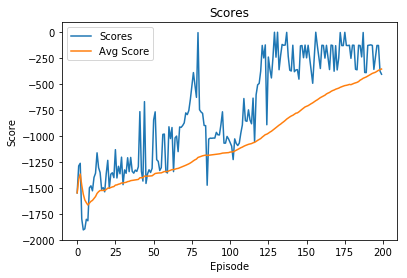

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

x = range(len(scores))
plt.plot(x, scores, label="Scores")
plt.plot(x, avg_scores, label="Avg Score")
plt.title("Scores")
plt.xlabel("Episode")
plt.ylabel("Score")
plt.legend()

In [14]:
env.close()